# Introduction

Goals:

* Identify alignment between tools in the tidyverse and panda equilavents (when they exist) or alternatives,
* Explain why the differences make sense so that python becomes more predictable to R users,
* Identify differences between the python plotnine implementation of ggplot2 and the original in R, and
* Give some workflow tips that will allow for more graceful data analysis



A Pandas `DataFrame` is very similar to an R `data.frame`.  One of the biggest differences is the use of indices in pandas.  Panda's supports single and multi level indices on both rows and columns that make very complicated selection possible.  Of course we know that *With great complication comes great complication.*  Just as many R users instinctively include the argument `stringsAsFactors=FALSE` when creating dataframes, many python users append `.reset_index()` on constructs to remove any indices that might have been created.  Although indices look much like ordinary columns they are not---they cannot be referenced in querys or used in aesthetic mappings in ggplot.  For the purpose of this course we will remove indices so that we can treat `DataFrame`s like `data.frame`s.

----

A difference in the underlying languages, R and Python, is that R uses lazy argument evaluation.  That means that for an expression like `do_something(2 + b)` python will evaluate `2+b` and provide that to the function while R will wrap `2+b` up in a `promise` object with enough context so that it can be evaluated if it is needed (that's the lazy bit.)  What that means for us is that arguments to an R function do not need to be evaluatable in the calling context, they are passed into the function where they can be put into a context where they are evaluatable.  For example, suppose a `data.frame` `df` has a column `height`.  In R we can filter by

```
df %>% filter(height > 1.75)
```
Internally what `filter` has done is collect the dataframe `df` from it's left argument, attached `df`'s namespace, and evaluated the text version of the argument from the promise object where is now makes sense since attaching `df` makes the symbol `height` resolvable.  If we try to do the same thing in python
```
df.query(height > 1.75)
```
We fail either gloriously (good) or silently (bad) depending on if the symbol `height` is defined in the calling context.  In either case `height` is not what we intended it to be.  In python we would need to include the selecting clause as a string and leave it to the function to parse and apply the predicate:
```
df.query('height > 1.75')
```
-----

Another benefit of lazy evaluation comes from pipes introduced into R by the `magrittr` package.  One would assume that to evaluate `a + b` one would need to know what `a` and `b` are before attempting to `+`.  But in R this is `plus(a,b)` and so `+` gets to decide what to do with `a` and `b` in their unevaluated state.  The tidyverse is easy to use because `magrittr` defines `a %>% f(c)` as `f(a,c)` so
```
df %>% filter(height > 1.75) %>% summarize(response=sum(response))
```
becomes
```
summarize(filter(df, height > 1.75), response=sum(response))
```
which is correct but reads from the inside out.

Python does not use lazy evaluation so we can't have pipes.  What python does have, however, is chaining.  In python everything is an object and objects have methods defined as `object.method()`.  As long as the method returns another object of an appropriate type we can keep chaining `object.method().method().method()`.  This can get us fairly close to pipes.  In python the above pipeline would look like
```
df.query('height > 1.75').agg({'response':sum}).reset_index()
```
Armed with a bucket of quotes and a wheelbarrow of `reset_index()`'s let's get started.

----
Further reference:
The pandas project provides a handy [reference](https://pandas.pydata.org/docs/getting_started/comparison/comparison_with_r.html) for pandas equivalents to R constructs.


In [ ]:
import pandas as pd
import numpy as np
import re

# we typically avoid import * to have a predictable namespace.  If we are not
# checking in the code it is OK.  If you need to check in code use
# import plotnine as gg
# and for every ggplot function prefix with gg. e.g. gg.ggplot(...) + gg.geom_point()
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format, currency_format

# compact print format
pd.options.display.max_rows = 8

# dplyr, tidyr -> pandas
[video](https://drive.google.com/file/d/1aqEIso9eIvCpjA_EGWEJ5ABxxKVSlS0m/view?usp=sharing) (20:18)

**Summary**:

The tidyverse benefits from a short development window with a clear design throughout.  Pandas, on the other hand, developed numerous different approaches over a long period of time leading to wildly different ways to achieve the same goal.  In this section I'll show a subset of these that can be chained together in a way that resembles idiomatic tidyverse usage.

## Pulling and examining data

Use the cell magic `%%f1_query` to enter an SQL query and store the results in pandas dataframe `gapminder`.  Use `.tail()` `.info()`, `.describe()`, and `.shape` to understand the dataframe.

In [ ]:
%%f1_query gapminder
select * from agkeck.gapminder LIMIT 10;

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved as pandas.core.frame.DataFrame to "gapminder"


In [ ]:
gapminder.head()

,country,continent,year,lifeexp,pop,gdppercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106


In [ ]:
gapminder.head(2)

,country,continent,year,lifeexp,pop,gdppercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030


In [ ]:
gapminder.tail()

,country,continent,year,lifeexp,pop,gdppercap
1699,Zimbabwe,Africa,1987,62.351,9216418,706.157306
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623
1703,Zimbabwe,Africa,2007,43.487,12311143,469.709298


In [ ]:
gapminder.sample(6)

,country,continent,year,lifeexp,pop,gdppercap
1368,Slovak Republic,Europe,1952,64.360,3558137,5074.659104
1077,Nepal,Asia,1997,59.426,23001113,1010.892138
1440,Sudan,Africa,1952,38.635,8504667,1615.991129
1411,South Africa,Africa,1987,60.834,35933379,7825.823398
396,Czech Republic,Europe,1952,66.870,9125183,6876.140250
779,Italy,Europe,2007,80.546,58147733,28569.719700


In [ ]:
gapminder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    1704 non-null   object 
 1   continent  1704 non-null   object 
 2   year       1704 non-null   int64  
 3   lifeexp    1704 non-null   float64
 4   pop        1704 non-null   int64  
 5   gdppercap  1704 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 80.0+ KB


In [ ]:
gapminder.describe()

,year,lifeexp,pop,gdppercap
count,1704.00000,1704.000000,1.704000e+03,1704.000000
mean,1979.50000,59.474439,2.960121e+07,7215.327081
std,17.26533,12.917107,1.061579e+08,9857.454543
min,1952.00000,23.599000,6.001100e+04,241.165876
25%,1965.75000,48.198000,2.793664e+06,1202.060309
50%,1979.50000,60.712500,7.023596e+06,3531.846988
75%,1993.25000,70.845500,1.958522e+07,9325.462346
max,2007.00000,82.603000,1.318683e+09,113523.132900


In [ ]:
gapminder.describe(include='all')

,country,continent,year,lifeexp,pop,gdppercap
count,1704,1704,1704.00,1704.0000,1.704000e+03,1704.000000
unique,142,5,NaN,NaN,NaN,NaN
top,Albania,Africa,NaN,NaN,NaN,NaN
freq,12,624,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
25%,NaN,NaN,1965.75,48.1980,2.793664e+06,1202.060309
50%,NaN,NaN,1979.50,60.7125,7.023596e+06,3531.846988
75%,NaN,NaN,1993.25,70.8455,1.958522e+07,9325.462346
max,NaN,NaN,2007.00,82.6030,1.318683e+09,113523.132900


In [ ]:
gapminder.shape

(1704, 6)

Sorting is accomplished with the `.sort_values()` method.

In [ ]:
gapminder.sort_values('pop', ascending=False).head()

,country,continent,year,lifeexp,pop,gdppercap
299,China,Asia,2007,72.961,1318683096,4959.114854
298,China,Asia,2002,72.028,1280400000,3119.280896
297,China,Asia,1997,70.426,1230075000,2289.234136
296,China,Asia,1992,68.690,1164970000,1655.784158
707,India,Asia,2007,64.698,1110396331,2452.210407


## Selecting subsets of data

**Selecting columns by name or position.**  dplyr uses the `select()` verb which understands a lot of different ways to extract columns.  Pandas has a number of different methods for extracting columns.  Two convenient choices are by name and by position.  Positional select requires the `.iloc()` method.

In [ ]:
# select three columns
gapminder[['country', 'year', 'pop']]

,country,year,pop
0,Afghanistan,1952,8425333
1,Afghanistan,1957,9240934
2,Afghanistan,1962,10267083
3,Afghanistan,1967,11537966
...,...,...,...
1700,Zimbabwe,1992,10704340
1701,Zimbabwe,1997,11404948
1702,Zimbabwe,2002,11926563
1703,Zimbabwe,2007,12311143


In [ ]:
# all rows, columns 0, 2, and 3
gapminder.iloc[:,[0, 2, 3]]

,country,year,lifeexp
0,Afghanistan,1952,28.801
1,Afghanistan,1957,30.332
2,Afghanistan,1962,31.997
3,Afghanistan,1967,34.020
...,...,...,...
1700,Zimbabwe,1992,60.377
1701,Zimbabwe,1997,46.809
1702,Zimbabwe,2002,39.989
1703,Zimbabwe,2007,43.487


**Selecting rows.** There are many ways to select rows.
* `.iloc()` as used above will work but you need to know the row numbers to be selected
* You can add an index and access by index values.  Indices are very powerful but do not map to ideas in the tidyverse so we won't discuss them here.
* You can create a series of booleans and select the rows with `True`.  This either requires creating and naming another object or a fairly complicated construction *in situ*.
* You can query the dataframe like an SQL table with `.query()`

The final approach is very readable and flexible enough for most uses.

In [ ]:
gapminder.query('year == 1997')

,country,continent,year,lifeexp,pop,gdppercap
9,Afghanistan,Asia,1997,41.763,22227415,635.341351
21,Albania,Europe,1997,72.950,3428038,3193.054604
33,Algeria,Africa,1997,69.152,29072015,4797.295051
45,Angola,Africa,1997,40.963,9875024,2277.140884
...,...,...,...,...,...,...
1665,West Bank and Gaza,Asia,1997,71.096,2826046,7110.667619
1677,"Yemen, Rep.",Asia,1997,58.020,15826497,2117.484526
1689,Zambia,Africa,1997,40.238,9417789,1071.353818
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960


Querying string columns requires nesting different types of strings or escaping.

In [ ]:
gapminder.query('continent == "Africa"')

,country,continent,year,lifeexp,pop,gdppercap
24,Algeria,Africa,1952,43.077,9279525,2449.008185
25,Algeria,Africa,1957,45.685,10270856,3013.976023
26,Algeria,Africa,1962,48.303,11000948,2550.816880
27,Algeria,Africa,1967,51.407,12760499,3246.991771
...,...,...,...,...,...,...
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623
1703,Zimbabwe,Africa,2007,43.487,12311143,469.709298


`and`, `or`, and `not` and `in` work as expected.

In [ ]:
gapminder.query('lifeexp > 75 or pop < 1500000')

,country,continent,year,lifeexp,pop,gdppercap
12,Albania,Europe,1952,55.230,1282697,1601.056136
13,Albania,Europe,1957,59.280,1476505,1942.284244
22,Albania,Europe,2002,75.651,3508512,4604.211737
23,Albania,Europe,2007,76.423,3600523,5937.029526
...,...,...,...,...,...,...
1659,West Bank and Gaza,Asia,1967,51.631,1142636,2649.715007
1660,West Bank and Gaza,Asia,1972,56.532,1089572,3133.409277
1661,West Bank and Gaza,Asia,1977,60.765,1261091,3682.831494
1662,West Bank and Gaza,Asia,1982,64.406,1425876,4336.032082


In [ ]:
gapminder.query('not gdppercap > 10000 ')

,country,continent,year,lifeexp,pop,gdppercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
...,...,...,...,...,...,...
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623
1703,Zimbabwe,Africa,2007,43.487,12311143,469.709298


In [ ]:
gapminder.query('country in ("Slovenia", "Niger")')

,country,continent,year,lifeexp,pop,gdppercap
1116,Niger,Africa,1952,37.444,3379468,761.879376
1117,Niger,Africa,1957,38.598,3692184,835.523402
1118,Niger,Africa,1962,39.487,4076008,997.766113
1119,Niger,Africa,1967,40.118,4534062,1054.384891
...,...,...,...,...,...,...
1388,Slovenia,Europe,1992,73.640,1999210,14214.716810
1389,Slovenia,Europe,1997,75.130,2011612,17161.107350
1390,Slovenia,Europe,2002,76.660,2011497,20660.019360
1391,Slovenia,Europe,2007,77.926,2009245,25768.257590


**Tip:**
One special case deserves mention because it solves a number of thorny problems.  The contents of a python list variable can be accessed inside of the query string by prepending the variable name with `@`. Here we pull out all data on countries with names starting with "W".

In [ ]:
w_countries = set(c for c in gapminder.country if c[0] == 'W')
gapminder.query('country in @w_countries')

,country,continent,year,lifeexp,pop,gdppercap
1656,West Bank and Gaza,Asia,1952,43.160,1030585,1515.592329
1657,West Bank and Gaza,Asia,1957,45.671,1070439,1827.067742
1658,West Bank and Gaza,Asia,1962,48.127,1133134,2198.956312
1659,West Bank and Gaza,Asia,1967,51.631,1142636,2649.715007
...,...,...,...,...,...,...
1664,West Bank and Gaza,Asia,1992,69.718,2104779,6017.654756
1665,West Bank and Gaza,Asia,1997,71.096,2826046,7110.667619
1666,West Bank and Gaza,Asia,2002,72.370,3389578,4515.487575
1667,West Bank and Gaza,Asia,2007,73.422,4018332,3025.349798


**Tip:**
If you are opposed to littering your namespace with throwaway variables like `w_countries` there is a more clever solution.  Any function that takes a dataframe as its first argument and returns a dataframe can be put into a chained evaluation that emulates `magrittr`'s pipe operator.  In this case we define such a function `mask()` that performs a selection by applying a boolean valued function to a named column.  This function is made a `pandas.DataFrame` instance method to allow chaining.

In [ ]:
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key column"""
  return df[function(df[key])]

pd.DataFrame.mask = mask

In [ ]:
gapminder.mask('country', lambda col: col.str.startswith('W'))

,country,continent,year,lifeexp,pop,gdppercap
1656,West Bank and Gaza,Asia,1952,43.160,1030585,1515.592329
1657,West Bank and Gaza,Asia,1957,45.671,1070439,1827.067742
1658,West Bank and Gaza,Asia,1962,48.127,1133134,2198.956312
1659,West Bank and Gaza,Asia,1967,51.631,1142636,2649.715007
...,...,...,...,...,...,...
1664,West Bank and Gaza,Asia,1992,69.718,2104779,6017.654756
1665,West Bank and Gaza,Asia,1997,71.096,2826046,7110.667619
1666,West Bank and Gaza,Asia,2002,72.370,3389578,4515.487575
1667,West Bank and Gaza,Asia,2007,73.422,4018332,3025.349798


Take note of the construct `col.str.startswith('W'))`. The `mask()` method is going to use the name of the column and feed that column into the lambda expression.  A column of a `DataFrame` is a numpy `Series` object.  Depending on datatype stored in the series there are differing sets of functions that have been vectorized over the series.  In this case we are holding a series of strings so the string specific methods are in `col.str.`.  For datetimes the interesting methods are in `col.dt.`.

----
There are many useful string functions that have been vectorized for pandas.  Regular expression matching is easy.  The construct `r'...'` is a string contructor that allows backslash characters to represent themselves instead of excape characters.  This form is often used in regular expressions.

In [ ]:
gapminder.mask('country', lambda col: col.str.match(r'.*and.*'))

,country,continent,year,lifeexp,pop,gdppercap
144,Bosnia and Herzegovina,Europe,1952,53.820,2791000,973.533195
145,Bosnia and Herzegovina,Europe,1957,58.450,3076000,1353.989176
146,Bosnia and Herzegovina,Europe,1962,61.930,3349000,1709.683679
147,Bosnia and Herzegovina,Europe,1967,64.790,3585000,2172.352423
...,...,...,...,...,...,...
1664,West Bank and Gaza,Asia,1992,69.718,2104779,6017.654756
1665,West Bank and Gaza,Asia,1997,71.096,2826046,7110.667619
1666,West Bank and Gaza,Asia,2002,72.370,3389578,4515.487575
1667,West Bank and Gaza,Asia,2007,73.422,4018332,3025.349798


### Exercises
1.   Select all data from 1960 on for Asia and the Americas.
2.   Find all countries with cardinal directions (east, west, north, south) in their names like West Bank and Gaza.  Don't include those names where the direction is incidental like Beastlandia.
2. Suppose that the life expectancy of country A is 44 years in 1955.  A typical citizen born that year would not be alive today.  Find all country/years with the property that a typical citizen born that year would not be a live today.

([solutions](https://colab.corp.google.com/drive/1ZBtOvIJImi7YXiLREQtH20lUgGb89-tC#scrollTo=jt-PZNpuAcDm&uniqifier=1))


Solutions:

## Mutation
[video](https://drive.google.com/file/d/135n_ZB7azHLbBL9mTA3sv4Sk1m9tpfXK/view?usp=sharing) (7:26)

Because pandas is build on numpy series objects that support vectorized operations, it is efficient to act on columns at a time.  The common technique of pulling out series, acting on them, and reassigning them back into a dataframe is not only unnecessarily verbose, it is also *un-chainable*.  Python does not allow us pipes but we will be able to *chain* transformations together and chains are nearly as good as pipes.

---
The `DataFrame` method to add a new column  is `assign()`.  This could be as simple as `df.assign(new_col=42)` which would create a new `DataFrame` with an additional column consisting of 42s.  Note that it returns the new frame, it does not operate in place.  Operating in place might save some resources but it makes chaining impossible, hence we always opt to return a modification of the original.

It is more realistic to `mutate()` (as R would call it) a `DataFrame` by adding a new column derived from other columns.  The difficulty comes from specifying the operation in terms of the columns of the 'current' `DataFrame`.  We might be in the middle of a chain of several operation so how do we refer to the columns of the current stage?  We provide a `lambda` expression which takes a `DataFrame` (the current frame) and returns a series as the new columns.  For instance to create a new column with twice a current column you could write
```
experiment.assign(doubled = lambda df: 2 * df.single)
```
Many will suggest this:
```
experiment.assign(doubled = 2 * experiment.single)
```
giving the `DataFrame` name explicitly.  Unfortunately this cannot be dropped into other settings and probably won't work in later stages of a chaining.


In [ ]:
# this happens in place and can't be part of a chain
gapminder['double_pop'] = 2 * gapminder['pop']

In [ ]:
# this can be chained but it is tied to the gapminder dataframe
gapminder.assign(double_pop = 2 * gapminder['pop'])

,country,continent,year,lifeexp,pop,gdppercap,double_pop
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,16850666
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,18481868
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,20534166
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,23075932
...,...,...,...,...,...,...,...
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786,21408680
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960,22809896
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623,23853126
1703,Zimbabwe,Africa,2007,43.487,12311143,469.709298,24622286


In [ ]:
# this can be chained and applied to any dataframe with a pop column
gapminder.assign(double_pop = lambda df: 2 * df['pop'])

,country,continent,year,lifeexp,pop,gdppercap,double_pop
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,16850666
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,18481868
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,20534166
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,23075932
...,...,...,...,...,...,...,...
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786,21408680
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960,22809896
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623,23853126
1703,Zimbabwe,Africa,2007,43.487,12311143,469.709298,24622286


In [ ]:
gapminder.assign(year_after_1970 = lambda df:df.year - 1970)

,country,continent,year,lifeexp,pop,gdppercap,double_pop,year_after_1970
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,16850666,-18
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,18481868,-13
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,20534166,-8
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,23075932,-3
...,...,...,...,...,...,...,...,...
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786,21408680,22
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960,22809896,27
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623,23853126,32
1703,Zimbabwe,Africa,2007,43.487,12311143,469.709298,24622286,37


If you assign to an existing name the new column replaces the original. In this case we convert life expectancy from years to months.

In [ ]:
gapminder.assign(lifeexp = lambda df: df.lifeexp * 12)

,country,continent,year,lifeexp,pop,gdppercap,double_pop
0,Afghanistan,Asia,1952,345.612,8425333,779.445314,16850666
1,Afghanistan,Asia,1957,363.984,9240934,820.853030,18481868
2,Afghanistan,Asia,1962,383.964,10267083,853.100710,20534166
3,Afghanistan,Asia,1967,408.240,11537966,836.197138,23075932
...,...,...,...,...,...,...,...
1700,Zimbabwe,Africa,1992,724.524,10704340,693.420786,21408680
1701,Zimbabwe,Africa,1997,561.708,11404948,792.449960,22809896
1702,Zimbabwe,Africa,2002,479.868,11926563,672.038623,23853126
1703,Zimbabwe,Africa,2007,521.844,12311143,469.709298,24622286


In [ ]:
pd.to_datetime('1952')

Timestamp('1952-01-01 00:00:00')

If you need to apply a non vectorized function to each element use the apply method to the series.  Here we convert year, a series of Int64s, into a series of strings.  This series is given to the vectorized function `pd.to_datetime()` which converts most anything that looks like a date time into a datetime. Had we simply given the Int64 values they would have been interpreted as nanoseconds after the epoch (1970-01-01).


In [ ]:
gapminder.assign(year = lambda df: pd.to_datetime(df.year.apply(str)))

,country,continent,year,lifeexp,pop,gdppercap,double_pop
0,Afghanistan,Asia,1952-01-01,28.801,8425333,779.445314,16850666
1,Afghanistan,Asia,1957-01-01,30.332,9240934,820.853030,18481868
2,Afghanistan,Asia,1962-01-01,31.997,10267083,853.100710,20534166
3,Afghanistan,Asia,1967-01-01,34.020,11537966,836.197138,23075932
...,...,...,...,...,...,...,...
1700,Zimbabwe,Africa,1992-01-01,60.377,10704340,693.420786,21408680
1701,Zimbabwe,Africa,1997-01-01,46.809,11404948,792.449960,22809896
1702,Zimbabwe,Africa,2002-01-01,39.989,11926563,672.038623,23853126
1703,Zimbabwe,Africa,2007-01-01,43.487,12311143,469.709298,24622286


### Exercises
1. Add a column to `gapminder` with the gdp.  We have population and gdp per capita so we can get total gdp with multiplication.
1. Add a column with the number of characters in the countries names.
1. Consider the following sequence:
$$
x_{n+1} = \begin{cases}
x_n/2 & \text{if $x_n$ is even}\\
3 x_n + 1 & \text{if $x_n$ is odd}
\end{cases}
$$
It is conjectured that for any $x_0$ this sequence will eventually terminate in the repeating sequence 4, 2, 1, 4, 2, 1, ... . Define `collatz(n)` to be the length of the sequence obtained by the above definition starting with $x_0 = n$ and ending the first time a 1 is generated.
Add a column with `collatz(pop)`.

([solutions](https://colab.corp.google.com/drive/1ZBtOvIJImi7YXiLREQtH20lUgGb89-tC#scrollTo=jt-PZNpuAcDm&uniqifier=1))


Solutions:

## Split Apply Combine
[video](https://drive.google.com/file/d/1Uwxd1spZcZyfSlJhEGxXJMGXgsZthDOG/view?usp=sharing) (14:34)

The split/apply/combine idiom is ubiquitous in data analysis and is well supported by pandas `groupby()` method.  Within the groups we can

* summarize columns into scalars
* transform columns, or
* apply a function to a dataframe consisting of the group in question.

Unlike dply where things were automatically coerced back into data frames, pandas returns objects that may need a little massaging for future use.

### Summarizing groups to scalars

Use the `agg()` method on the grouped data frame.  With a single callable argument, `agg(sum)`, for example, pandas will apply the `sum()` function to each column in the group, silently dropping those columns for which the function does not make sense (strings for instance).  For finer control this method also takes a dictionary of `column_name : function[s] to apply` entries and returns a dataframe with columns for each summarizer and an index consisting of distinct levels of the grouping variables.

In [ ]:
gapminder.groupby('country').agg({'pop':np.mean, 'gdppercap':np.median})

,pop,gdppercap
country,,
Afghanistan,1.582372e+07,803.483195
Albania,2.580249e+06,3253.238396
Algeria,1.987541e+07,4853.855903
Angola,7.309390e+06,3264.628814
...,...,...
West Bank and Gaza,1.848606e+06,3408.120386
"Yemen, Rep.",1.084319e+07,1854.630925
Zambia,6.353805e+06,1291.584180
Zimbabwe,7.641966e+06,678.813152


While the `country` column in the above dataframe looks innocent enough **do not be deceived**.  It is now an index.  We won't be able to use `query()` on that column, we won't be able to use that column in `ggplot()` and it will, in general, act in a magical and unexplanable manner.  (Of course indices are very powerful and much beloved by native pandanistas.  For those of us coming from the tidyverse they are a hinderance.)  We can fold the index `country` back into a column of the data frame with `reset_index()`.

In [ ]:
(gapminder
  .groupby('country')
  .agg({'pop':np.mean, 'gdppercap':np.median})
  .reset_index()
)

,country,pop,gdppercap
0,Afghanistan,1.582372e+07,803.483195
1,Albania,2.580249e+06,3253.238396
2,Algeria,1.987541e+07,4853.855903
3,Angola,7.309390e+06,3264.628814
...,...,...,...
138,West Bank and Gaza,1.848606e+06,3408.120386
139,"Yemen, Rep.",1.084319e+07,1854.630925
140,Zambia,6.353805e+06,1291.584180
141,Zimbabwe,7.641966e+06,678.813152


Applying multiple functions to a column produces, in addition to the requested summaries, a fresh problem, a multi index in the columns,

In [ ]:
gapminder.groupby('country').agg({'pop':[np.mean, np.std]})

pop              
                            mean           std
country                                       
Afghanistan         1.582372e+07  7.114583e+06
Albania             2.580249e+06  8.285855e+05
Algeria             1.987541e+07  8.613355e+06
Angola              7.309390e+06  2.672281e+06
...                          ...           ...
West Bank and Gaza  1.848606e+06  1.023057e+06
Yemen, Rep.         1.084319e+07  5.590408e+06
Zambia              6.353805e+06  3.096949e+06
Zimbabwe            7.641966e+06  3.376895e+06

[142 rows x 2 columns]

and `reset_index()` is not going to fix it.

In [ ]:
(gapminder
  .groupby('country')
  .agg({'pop':[np.mean, np.std]})
  .reset_index()
)

country           pop              
                                 mean           std
0           Afghanistan  1.582372e+07  7.114583e+06
1               Albania  2.580249e+06  8.285855e+05
2               Algeria  1.987541e+07  8.613355e+06
3                Angola  7.309390e+06  2.672281e+06
..                  ...           ...           ...
138  West Bank and Gaza  1.848606e+06  1.023057e+06
139         Yemen, Rep.  1.084319e+07  5.590408e+06
140              Zambia  6.353805e+06  3.096949e+06
141            Zimbabwe  7.641966e+06  3.376895e+06

[142 rows x 3 columns]

A nice solution I found in a tensorflow training is to add a instance method to `pd.DataFrame` to extract the multi index, stored as a tuple for each column, and flatten them with an underscore.  That this function returns the modified dataframe means that we can use this in a chain of operations.

In [ ]:
def flatten_cols(df):
  res = df.copy()
  res.columns = ['_'.join(col).strip('_') for col in res.columns.values]
  return res

pd.DataFrame.flatten_cols = flatten_cols

In [ ]:
(gapminder
  .groupby('country')
  .agg({'pop':[np.mean, np.std]})
  .reset_index()
  .flatten_cols()
)

,country,pop_mean,pop_std
0,Afghanistan,1.582372e+07,7.114583e+06
1,Albania,2.580249e+06,8.285855e+05
2,Algeria,1.987541e+07,8.613355e+06
3,Angola,7.309390e+06,2.672281e+06
...,...,...,...
138,West Bank and Gaza,1.848606e+06,1.023057e+06
139,"Yemen, Rep.",1.084319e+07,5.590408e+06
140,Zambia,6.353805e+06,3.096949e+06
141,Zimbabwe,7.641966e+06,3.376895e+06


### Modifying columns within a group.

The `transform()` method will apply a function to all columns within the groups so to standardize the data we could normalize with `lambda col: (col - np.mean(col))/np.std(col)`.  Unfortunately this method silently drops columns for which the transforming function can't be applied (`continent`) and also drops the column[s] by which the dataframe was grouped.  The resulting dataframe is severly limited in utility as a result.

In [ ]:
(gapminder
  .groupby('country')
  .transform(lambda col: (col - np.mean(col))/np.std(col))
)

,year,lifeexp,pop,gdppercap,double_pop
0,-1.593255,-1.777668,-1.086129,-0.224229,-1.086129
1,-1.303572,-1.464040,-0.966394,0.175474,-0.966394
2,-1.013890,-1.122962,-0.815749,0.486755,-0.815749
3,-0.724207,-0.708548,-0.629175,0.323588,-0.629175
...,...,...,...,...,...
1700,0.724207,1.139288,0.947185,0.449717,0.947185
1701,1.013890,-0.864626,1.163882,1.223397,1.163882
1702,1.303572,-1.871900,1.325216,0.282666,1.325216
1703,1.593255,-1.355266,1.444166,-1.298061,1.444166


### Modifying a group as a whole


The `apply()` method is the general solution for mutating groups.  We provide a function that takes a dataframe and returns a dataframe and pandas will arrange to apply the function to each group, collect the results, and concatenate them vertically.  The tricky bit here is that the grouping columns are promoted to a multiindex so if the function returns the grouping columns then when we call `reset_index()` there will be a name collision.  Therefore we can either drop the key columns in the return value from our function or drop the index columns after the apply with `reset_index(drop=True)` and all is well.  Here we standardize only the population column.  Since `pop()` is a dataframe method we can't access the `pop` column with `df.pop`.  Instead we access it by name as shown.  Also for clarity we enclose the entire expression in parentheses which allows us to break lines in a way that make the sequence of operations easier to parse.

In [ ]:
(gapminder
  .groupby('country')
  .apply(lambda grp: grp.assign(pop = (grp['pop'] - np.mean(grp['pop']))/np.std(grp['pop'])))
  .reset_index(drop=True)
)

,country,continent,year,lifeexp,pop,gdppercap,double_pop
0,Afghanistan,Asia,1952,28.801,-1.086129,779.445314,16850666
1,Afghanistan,Asia,1957,30.332,-0.966394,820.853030,18481868
2,Afghanistan,Asia,1962,31.997,-0.815749,853.100710,20534166
3,Afghanistan,Asia,1967,34.020,-0.629175,836.197138,23075932
...,...,...,...,...,...,...,...
1700,Zimbabwe,Africa,1992,60.377,0.947185,693.420786,21408680
1701,Zimbabwe,Africa,1997,46.809,1.163882,792.449960,22809896
1702,Zimbabwe,Africa,2002,39.989,1.325216,672.038623,23853126
1703,Zimbabwe,Africa,2007,43.487,1.444166,469.709298,24622286


If you need to specify the order for the rows in subgroups you can either `sort_values()` before the `groupby()` or within the function applied to the group. Here we create columns that compute growth and growthfactor in gdppercap relative to the first year's data.

In [ ]:
(gapminder
  .groupby('country')
  .apply(lambda grp: grp.sort_values('year')
                    .assign(gdppercap_growth=grp.gdppercap - grp.gdppercap.iloc[0],
                            growth_factor=grp.gdppercap / grp.gdppercap.iloc[0])
        )
  .reset_index(drop=True)
)

,country,continent,year,lifeexp,pop,gdppercap,double_pop,gdppercap_growth,growth_factor
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,16850666,0.000000,1.000000
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,18481868,41.407715,1.053125
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,20534166,73.655396,1.094497
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,23075932,56.751824,1.072811
...,...,...,...,...,...,...,...,...,...
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786,21408680,286.536671,1.704222
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960,22809896,385.565846,1.947606
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623,23853126,265.154508,1.651671
1703,Zimbabwe,Africa,2007,43.487,12311143,469.709298,24622286,62.825183,1.154406


In the above we used apply to apply a function to each group.  That function made an assignment.  This is an awkward way to implement the missing group-wise assigment problem.  The key idea is that we should be able to give a lambda expression that can handle one group and make that the right hand side of an assignment.  The following function takes its arguments and arranges for them to by applied in an assign on each group.  This function is assigned as a method for `groupby` objects.  (This is part of my standard [preamble](https://colab.corp.google.com/drive/1j4yM1BkLRd72PqdnF68gMwRSImOFmz2E))

In [ ]:
def _groupby_assign(self, **kwargs):
  return self.apply(lambda grp: grp.assign(**kwargs))

pd.core.groupby.generic.DataFrameGroupBy.assign = _groupby_assign


With this definition we can easily perform groupwise assignments.  For example if we want mean population for each country:

In [ ]:
(gapminder
  .groupby('country')
  .assign(mean_population = lambda grp: np.mean(grp['pop']))
  .reset_index(drop=True)
 )

,country,continent,year,lifeexp,pop,gdppercap,double_pop,mean_population
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,16850666,1.582372e+07
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,18481868,1.582372e+07
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,20534166,1.582372e+07
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,23075932,1.582372e+07
...,...,...,...,...,...,...,...,...
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786,21408680,7.641966e+06
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960,22809896,7.641966e+06
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623,23853126,7.641966e+06
1703,Zimbabwe,Africa,2007,43.487,12311143,469.709298,24622286,7.641966e+06


### Exercises

1. Find the total GDP and GDP per capita for each continent and year.
1. Extract the rows which hold the maximal percapita gdp for each country (i.e. one row for each country.)
1. For each continent, calculate the mean population for each country in the continent, order the countries by decreasing mean population, and add a column with cumulative percent of the continent's population accounted for so far.  For example:

continent | country | mean_pop | cum_percent
----------|--------|---------|---------------
A | a | 50 | 0.5
A | b | 30 | 0.8
A | c | 20 | 1.0
B | d | 30 | 0.75
B | e | 6  | 0.9
B | f | 2  | 0.95
B | g | 2  | 1.0

3. Add a column with the 5 year population growth (population - previous population) for each country.  (Hint: the `shift()` method will give the value of a column at an offset.  `df.column.shift()` gives the value of `column` in the previous row.)
3. For each continent, year, rank the countries in the continent by gdppercap (descending) i.e. the country with the highest percapita gdp is rank 1.

([solutions](https://colab.corp.google.com/drive/1ZBtOvIJImi7YXiLREQtH20lUgGb89-tC#scrollTo=jt-PZNpuAcDm&uniqifier=1))

Solutions:

## Joins
[video](https://drive.google.com/file/d/1BfZ6QeD90lX8timzR3hgl-lxkKAedM0i/view?usp=sharing) (4:50)

The pandas `join()` method works nicely with indices.  As mentioned before, indices are powerful but non intuitive to those coming from the tidyverse.  The method `merge()` performs the same task but it is more like SQL and dplyr's `join()` method.

---
The basic syntax is

```
left_dataframe.merge(right_dataframe, on= , how=)
```
Where `on` specifies the key columns for the join and `how` specifies `inner`, `outer`, `left` or `right`.

In this case we wish to augment the dataframe with yearly continent wide population.  We first create the yearly continent totals and then join with the original on continent and year.  We rename the column name to avoid name collison in the join although pandas will add suffixes to ensure unique names.

While we are at it we can add a new column with the fraction of the continent's total population represented by each country each year.


In [ ]:
(gapminder
  .groupby(['continent', 'year'])
  .agg({'pop':np.sum})
  .reset_index()
  .rename(columns={'pop':'continental_pop'})
  .merge(gapminder, on=['continent', 'year'], how='right')
  .assign(pop_frac = lambda df: df['pop']/df.continental_pop)
)

,continent,year,continental_pop,country,lifeexp,pop,gdppercap,double_pop,pop_frac
0,Asia,1952,1395357351,Afghanistan,28.801,8425333,779.445314,16850666,0.006038
1,Asia,1952,1395357351,Bahrain,50.939,120447,9867.084765,240894,0.000086
2,Asia,1952,1395357351,Bangladesh,37.484,46886859,684.244172,93773718,0.033602
3,Asia,1952,1395357351,Cambodia,39.417,4693836,368.469286,9387672,0.003364
...,...,...,...,...,...,...,...,...,...
1700,Oceania,2002,23454829,Australia,80.370,19546792,30687.754730,39093584,0.833380
1701,Oceania,2002,23454829,New Zealand,79.110,3908037,23189.801350,7816074,0.166620
1702,Oceania,2007,24549947,Australia,81.235,20434176,34435.367440,40868352,0.832351
1703,Oceania,2007,24549947,New Zealand,80.204,4115771,25185.009110,8231542,0.167649


The above example uses a join to perform what is essentially an analytic function.  A more straightforward approach would be to apply a function that assigns group totals to a grouped object as follows. *Thanks to rsylvain@ for the suggestion*

In [ ]:
  (gapminder
   .groupby(['continent', 'year'])
   .apply(lambda grp: grp.assign(continental_pop = np.sum(grp['pop'])))
   .assign(pop_frac = lambda df: df['pop']/df['continental_pop'])
   .reset_index(drop=True)
  )

,country,continent,year,lifeexp,pop,gdppercap,double_pop,continental_pop,pop_frac
0,Algeria,Africa,1952,43.077,9279525,2449.008185,18559050,237640501,0.039049
1,Angola,Africa,1952,30.015,4232095,3520.610273,8464190,237640501,0.017809
2,Benin,Africa,1952,38.223,1738315,1062.752200,3476630,237640501,0.007315
3,Botswana,Africa,1952,47.622,442308,851.241141,884616,237640501,0.001861
...,...,...,...,...,...,...,...,...,...
1700,Australia,Oceania,2002,80.370,19546792,30687.754730,39093584,23454829,0.833380
1701,New Zealand,Oceania,2002,79.110,3908037,23189.801350,7816074,23454829,0.166620
1702,Australia,Oceania,2007,81.235,20434176,34435.367440,40868352,24549947,0.832351
1703,New Zealand,Oceania,2007,80.204,4115771,25185.009110,8231542,24549947,0.167649


It is a common need to make assignments to a grouped object and Pandas does not provide it directly.  The pattern seen above, however can be encoded into a method that can be called on `groupby` objects to produce the required assign.  First we define the transformation and assign it as a method.

In [ ]:
def _groupby_assign(self, **kwargs):
  return self.apply(lambda grp: grp.assign(**kwargs))

pd.core.groupby.generic.DataFrameGroupBy.assign = _groupby_assign

We can now directly assign to a `groupby` object without the gynmastics.

In [ ]:
  (gapminder
   .groupby(['continent', 'year'])
   .assign(continental_pop = lambda df: np.sum(df['pop']))
   .assign(pop_frac = lambda df: df['pop']/df['continental_pop'])
   .reset_index(drop=True)
  )

,country,continent,year,lifeexp,pop,gdppercap,double_pop,continental_pop,pop_frac
0,Algeria,Africa,1952,43.077,9279525,2449.008185,18559050,237640501,0.039049
1,Angola,Africa,1952,30.015,4232095,3520.610273,8464190,237640501,0.017809
2,Benin,Africa,1952,38.223,1738315,1062.752200,3476630,237640501,0.007315
3,Botswana,Africa,1952,47.622,442308,851.241141,884616,237640501,0.001861
...,...,...,...,...,...,...,...,...,...
1700,Australia,Oceania,2002,80.370,19546792,30687.754730,39093584,23454829,0.833380
1701,New Zealand,Oceania,2002,79.110,3908037,23189.801350,7816074,23454829,0.166620
1702,Australia,Oceania,2007,81.235,20434176,34435.367440,40868352,24549947,0.832351
1703,New Zealand,Oceania,2007,80.204,4115771,25185.009110,8231542,24549947,0.167649


### Exercises

1. Use a merge to add a column to gapminder with the number of countries in the continent. For example, there are 52 countries in Africa (according to gapminder) so every row for an african country should have 52 in the new column.
2. Use an outer merge and query to find country and years where the countries' population decreased (note: population is measured every five years).

([solutions](https://colab.corp.google.com/drive/1ZBtOvIJImi7YXiLREQtH20lUgGb89-tC#scrollTo=jt-PZNpuAcDm&uniqifier=1))

Solutions:

## Reshape Data

###Long to Wide.

The `pivot_table()` method will convert long to wide.  In this example we want a wide table for population with columns being the years.  There is also a `pivot()` method that works similarly but does not handle multi indices (i.e. if I want both continent and country columns.)

In [ ]:
wide = (gapminder
          .pivot_table(index='country', columns = 'year', values = 'pop')
          .reset_index()
          .rename_axis(columns=None)
        )
wide

,country,1952,1957,1962,1967,1972,1977,1982,1987,1992,1997,2002,2007
0,Afghanistan,8425333,9240934,10267083,11537966,13079460,14880372,12881816,13867957,16317921,22227415,25268405,31889923
1,Albania,1282697,1476505,1728137,1984060,2263554,2509048,2780097,3075321,3326498,3428038,3508512,3600523
2,Algeria,9279525,10270856,11000948,12760499,14760787,17152804,20033753,23254956,26298373,29072015,31287142,33333216
3,Angola,4232095,4561361,4826015,5247469,5894858,6162675,7016384,7874230,8735988,9875024,10866106,12420476
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,West Bank and Gaza,1030585,1070439,1133134,1142636,1089572,1261091,1425876,1691210,2104779,2826046,3389578,4018332
139,"Yemen, Rep.",4963829,5498090,6120081,6740785,7407075,8403990,9657618,11219340,13367997,15826497,18701257,22211743
140,Zambia,2672000,3016000,3421000,3900000,4506497,5216550,6100407,7272406,8381163,9417789,10595811,11746035
141,Zimbabwe,3080907,3646340,4277736,4995432,5861135,6642107,7636524,9216418,10704340,11404948,11926563,12311143


You can also use the `unstack()` method if you have selected the columns you want and set the proper index.  This will give you the correct shape but you'll also have a hierarchical column index to contend with and in this case the components are both string and integer so you'll need to adjust the `flatten_cols()` method to handle this.

In [ ]:
(gapminder[['country', 'year', 'pop']]
  .set_index(['country','year'])
  .unstack()
  .reset_index()
)

country      pop            ...                              
year                         1952      1957  ...      1997      2002      2007
0            Afghanistan  8425333   9240934  ...  22227415  25268405  31889923
1                Albania  1282697   1476505  ...   3428038   3508512   3600523
2                Algeria  9279525  10270856  ...  29072015  31287142  33333216
3                 Angola  4232095   4561361  ...   9875024  10866106  12420476
..                   ...      ...       ...  ...       ...       ...       ...
138   West Bank and Gaza  1030585   1070439  ...   2826046   3389578   4018332
139          Yemen, Rep.  4963829   5498090  ...  15826497  18701257  22211743
140               Zambia  2672000   3016000  ...   9417789  10595811  11746035
141             Zimbabwe  3080907   3646340  ...  11404948  11926563  12311143

[142 rows x 13 columns]

###Wide to Long

The wide to long transformation can be performed with the `melt` method.  Melting can be fairly complicated but in simple cases you can give the columns that form identifiers for cases and all the remaining columns will be gathered.  If you can easily list those columns or remove the unwanted columm melting works very well.

In [ ]:
wide.melt(id_vars='country', var_name='year', value_name='pop')

,country,year,pop
0,Afghanistan,1952,8425333
1,Albania,1952,1282697
2,Algeria,1952,9279525
3,Angola,1952,4232095
...,...,...,...
1700,West Bank and Gaza,2007,4018332
1701,"Yemen, Rep.",2007,22211743
1702,Zambia,2007,11746035
1703,Zimbabwe,2007,12311143


Pandas provides a class method `pd.wide_to_long()` that is designed to handle common cases.  The columns to be gathered need to share a common prefix.  In the previous example we created a wide dataframe with columns for years (column names are `int64`).  To recast this in long format we need to add a common prefix to the year columns.  We do this using a function to map old column names to new column names.

In [ ]:
wide_with_prefix = wide.rename(columns = lambda cname: 'pop_'+str(cname) if re.match(r'\d{4}',str(cname)) else cname)
wide_with_prefix

year,country,pop_1952,pop_1957,pop_1962,pop_1967,pop_1972,pop_1977,pop_1982,pop_1987,pop_1992,pop_1997,pop_2002,pop_2007
0,Afghanistan,8425333,9240934,10267083,11537966,13079460,14880372,12881816,13867957,16317921,22227415,25268405,31889923
1,Albania,1282697,1476505,1728137,1984060,2263554,2509048,2780097,3075321,3326498,3428038,3508512,3600523
2,Algeria,9279525,10270856,11000948,12760499,14760787,17152804,20033753,23254956,26298373,29072015,31287142,33333216
3,Angola,4232095,4561361,4826015,5247469,5894858,6162675,7016384,7874230,8735988,9875024,10866106,12420476
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,West Bank and Gaza,1030585,1070439,1133134,1142636,1089572,1261091,1425876,1691210,2104779,2826046,3389578,4018332
139,"Yemen, Rep.",4963829,5498090,6120081,6740785,7407075,8403990,9657618,11219340,13367997,15826497,18701257,22211743
140,Zambia,2672000,3016000,3421000,3900000,4506497,5216550,6100407,7272406,8381163,9417789,10595811,11746035
141,Zimbabwe,3080907,3646340,4277736,4995432,5861135,6642107,7636524,9216418,10704340,11404948,11926563,12311143


`pd.wide_to_long()` determines the columns to be gathered by matching column names to the form `<prefix><sep><suffix>`.

`pd.wide_to_long()` takes as arguments:

* `stubnames` one or more prefixes for columns to gather
* `i` one or more index columns to be repeated as necessary in the long dataframe
* `sep` a string separating the prefix from the value in columns to be gathered.  The separator is removed.
* `j` a label for the column created by the gather
* `suffix` a regular expression that matches the third part of the column names to be gathered.

In [ ]:
(pd.wide_to_long(wide_with_prefix,
                 stubnames='pop',
                 sep='_',
                 i='country',
                 j='year',
                 suffix='\d+')
  .reset_index()
)

,country,year,pop
0,Afghanistan,1952,8425333
1,Albania,1952,1282697
2,Algeria,1952,9279525
3,Angola,1952,4232095
...,...,...,...
1700,West Bank and Gaza,2007,4018332
1701,"Yemen, Rep.",2007,22211743
1702,Zambia,2007,11746035
1703,Zimbabwe,2007,12311143


# ggplot -> plotnine

## plotnine
[video](https://drive.google.com/file/d/12JBNFj-eOtI2vagN_xgZHa8eTTJcaKDr/view?usp=sharing) (21:46)

There are two implementations of the grammar of graphics for python.  One is called `ggplot`, the other `plotnine`.  The former is no longer in active development (as of 2020-08) so the latter is a safer choice.  In general here is how to get results very similar to `ggplot2`


* enclose column names in quotes
* for some styling elements (e.g. panel background) R can use `.` as an ordinary character but in python it is member access so `panel.background` in R turns into `panel_background` in plotnine.
* incomplete lines in python throw errors so multiline plotting commands need
to be parenthesised:



```
plotname = ( ggplot(...) + geom_thing(...) + theme(...) +
             labs(...) )
```



## Examples

There are many excellent tutorial on using `ggplot` and `plotnine`

* external documentation: [here](https://www.kaggle.com/princeashburton/an-intro-to-plotnine), [here](http://www.mbel.io/2019/08/06/introduction-to-plotnine-ggplot-port-in-python/), and [here](https://dputhier.github.io/jgb53d-bd-prog_github/practicals/intro_ggplot/intro_ggplot.html) for starters.
* internal documentation: go/plotnine and [colab example](https://colab.corp.google.com/notebooks/charts_plotnine.ipynb#forceEdit=true&sandboxMode=true&offline=1&poolId=colaboratory-playground-default),

so I won't repeat a full introduction.  The basic idea is that a statistical graph has a mapping of data columns to *aesthetic* dimensions of the plot.  The most commonly used dimensions are `x` and `y` position, `color`, and `size` and `alpha` (opacity).  These aesthetics are mapped into geometric objects `point`, `line`, `boxplot`, `errorbar`, and many more either directly or after applying associated statistics. Coordinate systems and axis scaling can be applied to the results.  A valuable part of the system is that any number of layers can be placed on the plot with each layer inheriting the data and aesthetics of the plot with the option of overriding.  With this you can show both the actual data along with summary statistics or fitted models.

A simple plot of life expectancy vs gdp per capita.  Lost in this representation is the identity of countries and the passage of time.

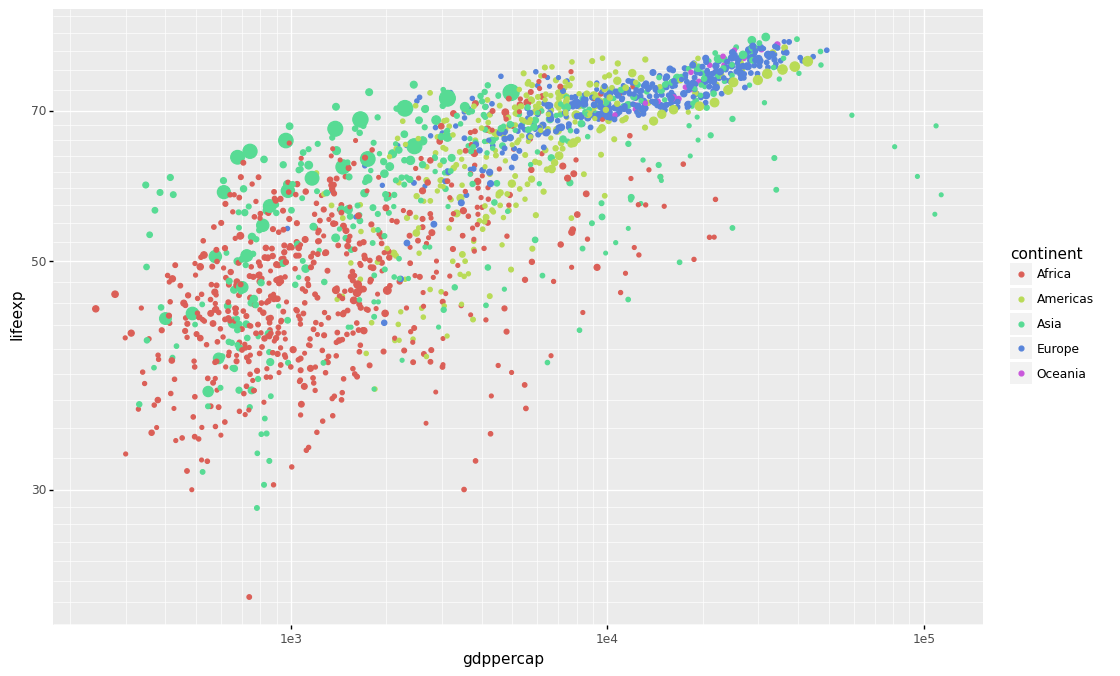

<ggplot: (8761982599927)>

In [ ]:
(ggplot(gapminder, aes(x='gdppercap', y='lifeexp',color='continent', size='pop'))
  + geom_point()
  + scale_y_log10()
  + scale_x_log10()
  + guides(size=None) # we remove the size guide since we don't expect people to read size data
  + theme(figure_size=(12,8))
)

* Limit the data to countries in the americas
* Move `size` aesthetic from the main plot to just the geom where it is used `point` so the `line` geom won't be scaled.
* Use a line aesthetic to represent time.
* Reduce opacity (`alpha` aesthetic) to reduce visual noise
* Give currency format to `y` axis
* Add labels.
* Increase size.

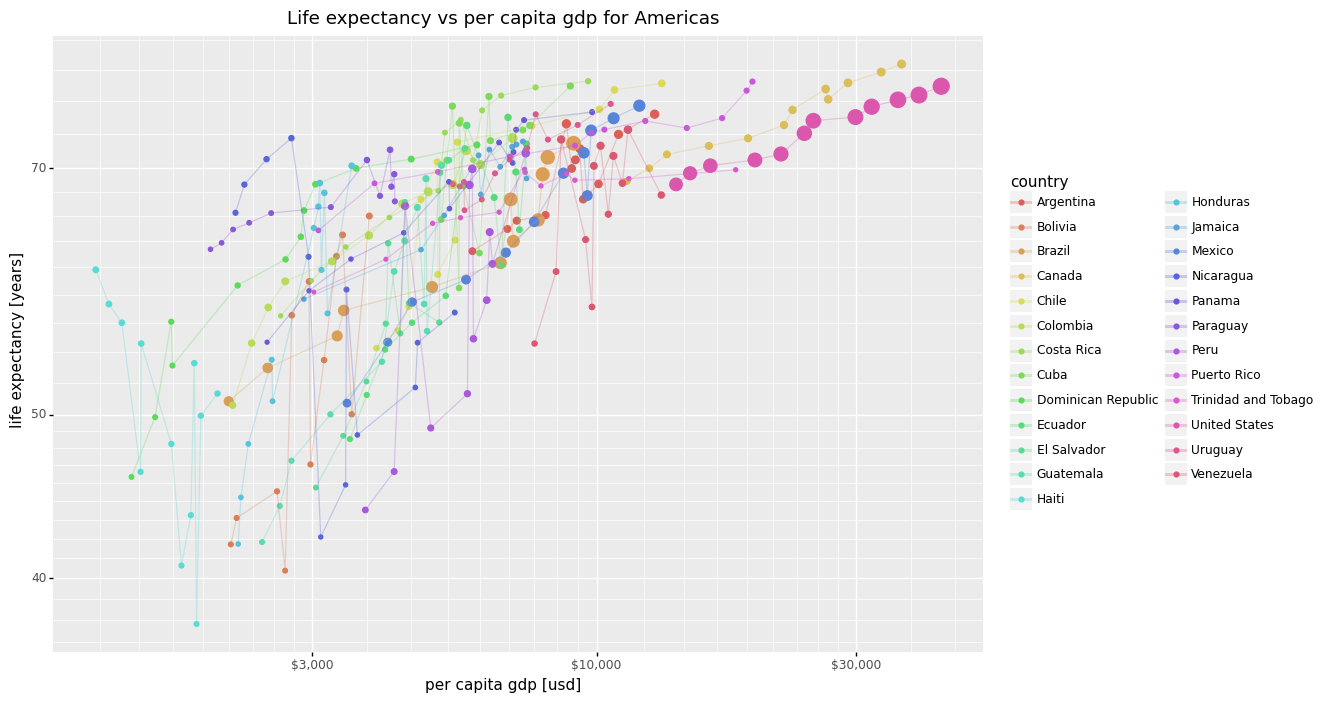

<ggplot: (8761982498567)>

In [ ]:
(ggplot(gapminder.query('continent == "Americas"'), aes(x='gdppercap', y='lifeexp', color='country'))
  + geom_point(aes(size='pop'))
  + geom_line(alpha=0.3)
  + scale_y_log10()
  + scale_x_log10(labels=currency_format(digits=0, big_mark=','))
  + guides(size=None)
  + labs(title='Life expectancy vs per capita gdp for Americas',
         x='per capita gdp [usd]',
         y='life expectancy [years]')
  + theme(figure_size=(12,8))
)

A boxplot

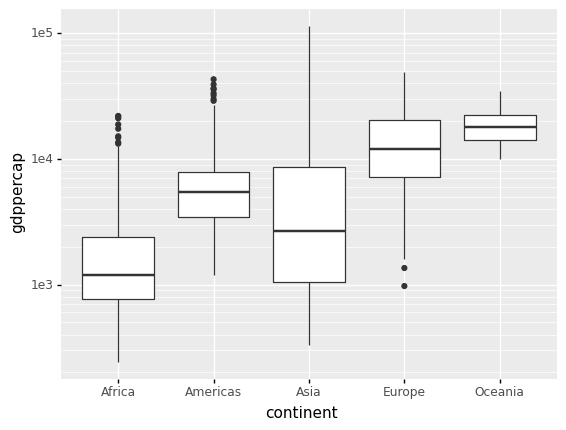

<ggplot: (8761981349717)>

In [ ]:
(ggplot(gapminder, aes(x='continent', y='gdppercap'))
  + geom_boxplot()
  + scale_y_log10()
)

* superimpose the boxplot over the data themselves.
* use jitter (in the width) to avoid overplotting

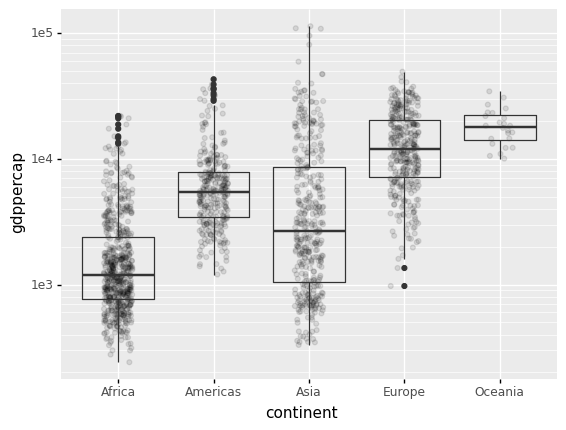

<ggplot: (8761981245913)>

In [ ]:
(ggplot(gapminder, aes(x='continent', y='gdppercap'))
  + geom_point(position=position_jitter(width=0.15), alpha=0.1)
  + geom_boxplot(alpha=0) # transparent fill in the boxplot
  + scale_y_log10()
)

* Small multiples: facet by year to look for patterns over time.

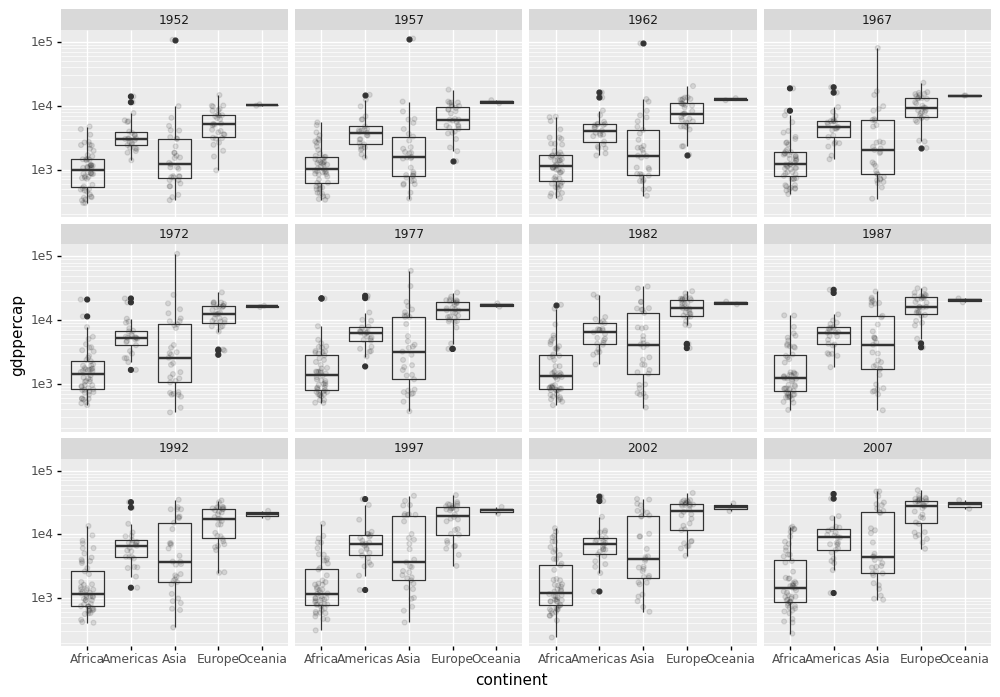

<ggplot: (8761988239921)>

In [ ]:
(ggplot(gapminder, aes(x='continent', y='gdppercap'))
  + geom_point(position=position_jitter(width=0.15), alpha=0.1)
  + geom_boxplot(alpha=0)
  + facet_wrap('year')
  + scale_y_log10()
  + theme(figure_size=(12,8))
)

* density plots by year

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_15.kernel.colaboratory-playground.3177010124220.14b334fb3717c109/mount/server/notebook.par/google3/third_party/py/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_15.kernel.colaboratory-playground.3177010124220.14b334fb3717c109/mount/server/notebook.par/google3/third_party/py/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


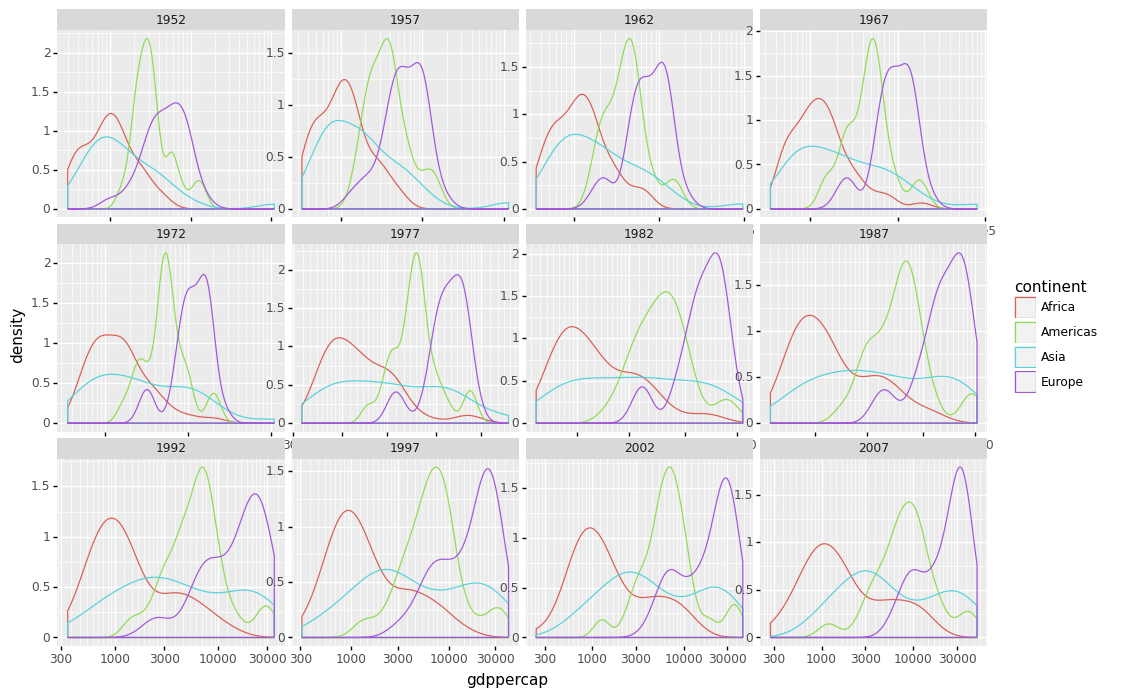

<ggplot: (8761982509927)>

In [ ]:
(ggplot(gapminder.query('continent != "Oceania"'), aes(x='gdppercap', color='continent'))
  + geom_density()
  + facet_wrap('year', scales='free')
  + scale_x_log10()
  + theme(figure_size=(12,8))
)

### Exercises
1. Create one or more plots that explore life expectancy over time.  These plots should both show overall patterns and make it possible to pick out exceptions to the overall pattern.
2. Create one or more plots that explore the distributions of per capita gdp within continents.  The question to answer here is if inequality is changing in different ways in different continents.
3. If population is growing exponentially then it will be linear in semilog scale (log y axis).  Choose a continent and devise a graphic to explore which countries are following exponential growth patterns.  (Hint: `geom_smooth(method='lm', se=False)` will generate a layer with a linear fit to the data.

([solutions](https://colab.corp.google.com/drive/1ZBtOvIJImi7YXiLREQtH20lUgGb89-tC#scrollTo=jt-PZNpuAcDm&uniqifier=1))

Solutions:

## Adding ggplot to pandas.
[video](https://drive.google.com/file/d/11dyxJnxEEa9akZBc6I4Y5Ah9MtMPqfKQ/view?usp=sharing) (17:00)

Pandas data frames have built in plotting methods which are based on Seaborn.  There are occasions when these are convenient for quick plots.

<AxesSubplot:xlabel='year'>

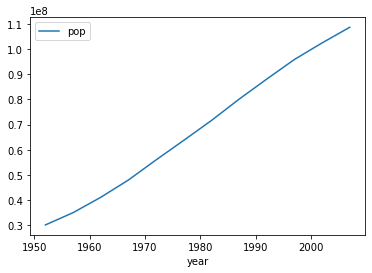

In [ ]:
gapminder.query('country == "Mexico"').plot(x='year', y='pop')

You can get similar functionality by adding a instance method, `ggplot()` to pandas dataframes as follows.  Add the method in your preamble.

In [ ]:
def _ggplot(self, *argv, **kwargs):
  return ggplot(data=self, *argv, **kwargs)

pd.DataFrame.ggplot = _ggplot

And enjoy ggplot goodness everywhere.

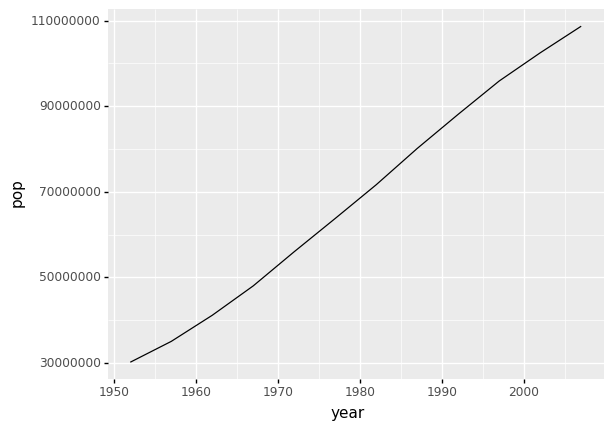

<ggplot: (8761980387949)>

In [ ]:
(gapminder
  .query('country == "Mexico"')
  .ggplot(aes(x='year', y='pop'))
  + geom_line()
)

## Getting publication quality graphics

In R one can use the `ggsave()` command to save graphics in a vector format for higher quality printing.  When running on a borg kernel it is not obvious where to save.  Here is a solution which, while not beautiful does the job.

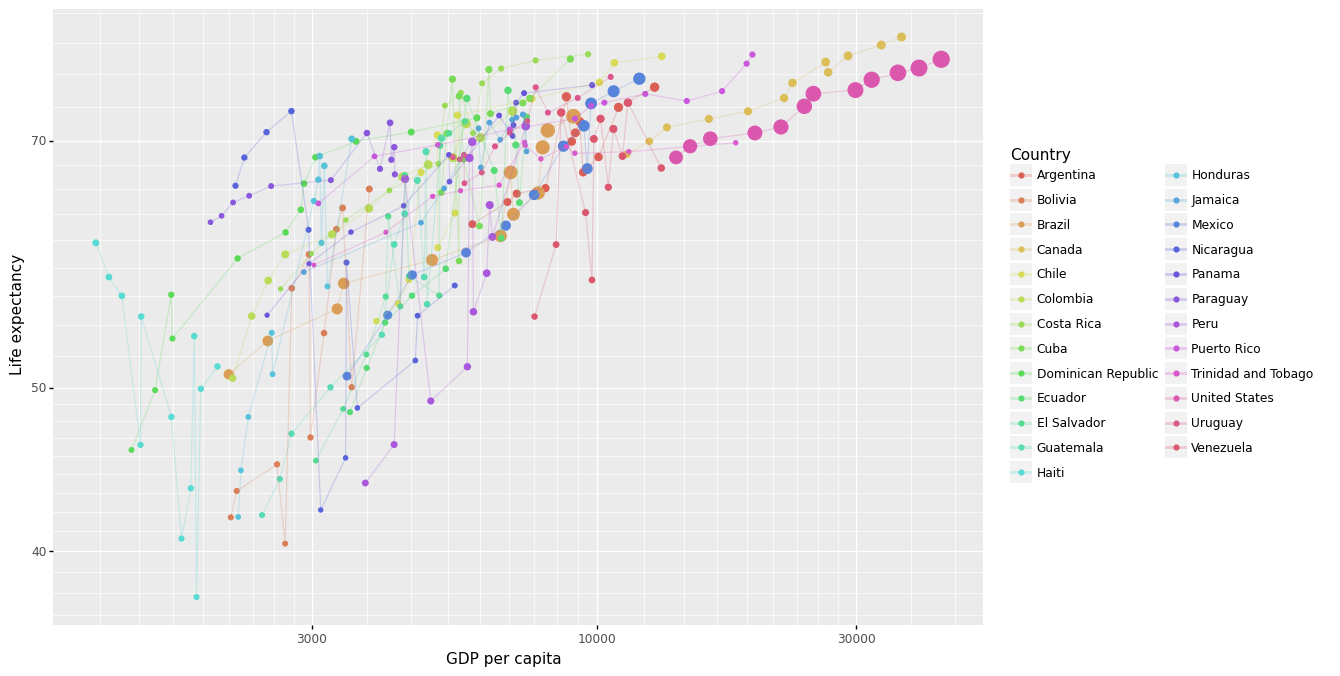

<ggplot: (8761980391084)>

In [ ]:
good_plot = (gapminder
             .query('continent == "Americas"')
             .ggplot(aes(x='gdppercap', y='lifeexp', color='country'))
             + geom_point(aes(size='pop'))
             + geom_line(alpha=0.25)
             + scale_y_log10()
             + scale_x_log10()
             + guides(size=None)
             + labs(x='GDP per capita', y='Life expectancy', color='Country')
             + theme(figure_size=(12, 8))
             )
good_plot

In [ ]:
%%multicell
graphic_name = "good_plot" #@param {type:"string"}
format = "pdf" #@param {type:"string"}
%%endcell
%%substitute_globals magic
%hide_stream

ggsave(filename = '/tmp/{graphic_name}.{format}', plot={graphic_name})
%download_file /tmp/{graphic_name}.{format}

<IPython.core.display.Javascript object>

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_15.kernel.colaboratory-playground.3177010124220.14b334fb3717c109/mount/server/notebook.par/google3/third_party/py/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 8 in image.
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_15.kernel.colaboratory-playground.3177010124220.14b334fb3717c109/mount/server/notebook.par/google3/third_party/py/plotnine/ggplot.py:722: PlotnineWarning: Filename: /tmp/good_plot.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# A few useful functions

Here are some functions that I include in the preamble of my basic [analysis notebook](https://colab.corp.google.com/drive/1j4yM1BkLRd72PqdnF68gMwRSImOFmz2E). They provide instance methods for common uses.  It is easy to create these provided your function takes a dataframe as first argument, returns a dataframe, and does not modify the dataframe in place.  In some cases I make a copy of the argument and modify that.  These function provide:

* `ggplot()` as a instance method so that one can perform data transformations in a chain of pandas operation and then visualize without having to name intermediate results
* `set_categorical()` that takes the name of a column to be made categorical (factor in R), a column of values to be aggregated to provide ordering, and returns the dataframe with the column as categorical.  Note that the ordering is the ordering of the labels used to display categories, not a true ordered factor.  You can get those of course but this is for ordering of facets and display on axes.
* `remove_unused_categories()` after filtering a data frame with `query()` one frequently wants to remove the categories that are no longer germane.
* `reverse_categories()` just what you think.

In [ ]:
def _ggplot(self, *argv, **kwargs):
  return ggplot(data=self, *argv, **kwargs)


def _set_categorical(self, category_col, value_col, aggregator=np.mean, ascending=False):
  res = self.copy()
  sort_data = (res
               .groupby(category_col)
               .agg({value_col:aggregator})
               .reset_index()
               .sort_values(value_col, ascending=ascending)
               )
  res.loc[:, category_col] = pd.Categorical(res.loc[:, category_col], categories = np.asarray(sort_data.loc[:, category_col]))
  return res


def _remove_unused_categories(df: pd.DataFrame):
    res = df.copy()
    for c in res.columns:
        if pd.api.types.is_categorical_dtype(res[c]):
            res[c].cat.remove_unused_categories(inplace=True)
    return res


def _reverse_categories(self, cat_column):
  res = self.copy()
  new_categorical = pd.Categorical(res[cat_column],categories=res[cat_column].values.categories[::-1])
  res[cat_column] = new_categorical
  return res


def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  res = df.copy()
  res.columns = ['_'.join(col).strip('_') for col in res.columns.values]
  return res

pd.DataFrame.ggplot = _ggplot
pd.DataFrame.set_categorical = _set_categorical
pd.DataFrame.remove_unused_categories = _remove_unused_categories
pd.DataFrame.reverse_categories = _reverse_categories
pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols


### More examples

With these functions we can start with a raw dataframe, mutate into the form we need and then visualize the results.  In this way the entire path from raw data to final visualizion is in one place and is self documenting.  For instance, suppose we want world population by year.

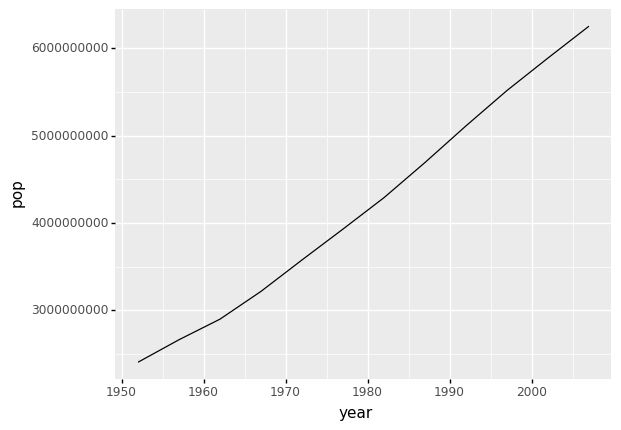

<ggplot: (8761980134129)>

In [ ]:
(gapminder
  .groupby('year')
  .agg(sum)
  .reset_index()
  .ggplot(aes(x='year', y='pop'))
  + geom_line()
)

* facet by continent.  Order the facets by population

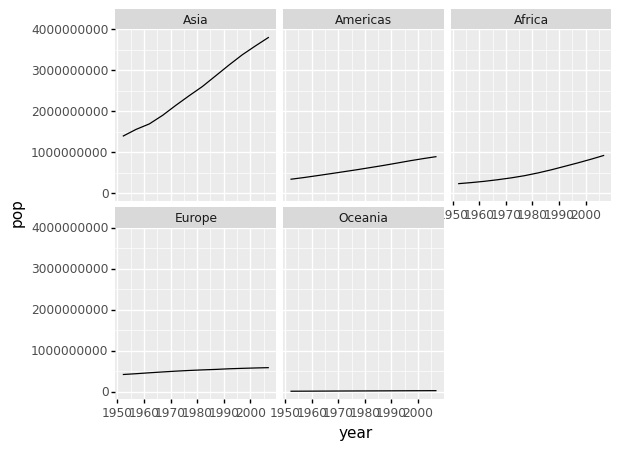

<ggplot: (8761980071382)>

In [ ]:
(gapminder
  .groupby(['year','continent'])
  .agg(sum)
  .reset_index()
  .set_categorical('continent', 'pop')
  .ggplot(aes(x='year', y='pop'))
  + geom_line()
  + facet_wrap('continent')
)

* boxplot of life expectancies ordered by mean expectancy

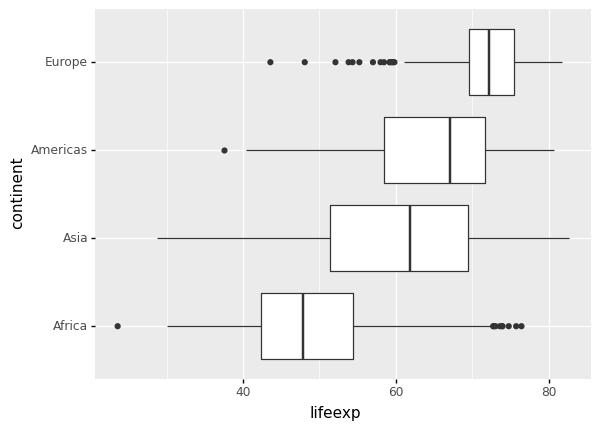

<ggplot: (8761980237912)>

In [ ]:
(gapminder
  .query('continent != "Oceania"')
  .set_categorical('continent', 'lifeexp', aggregator=np.median, ascending=True)
  .ggplot(aes(x='continent', y='lifeexp'))
  + geom_boxplot()
  + coord_flip()
)

 A braid chart showing population rank over time for countries in Africa.

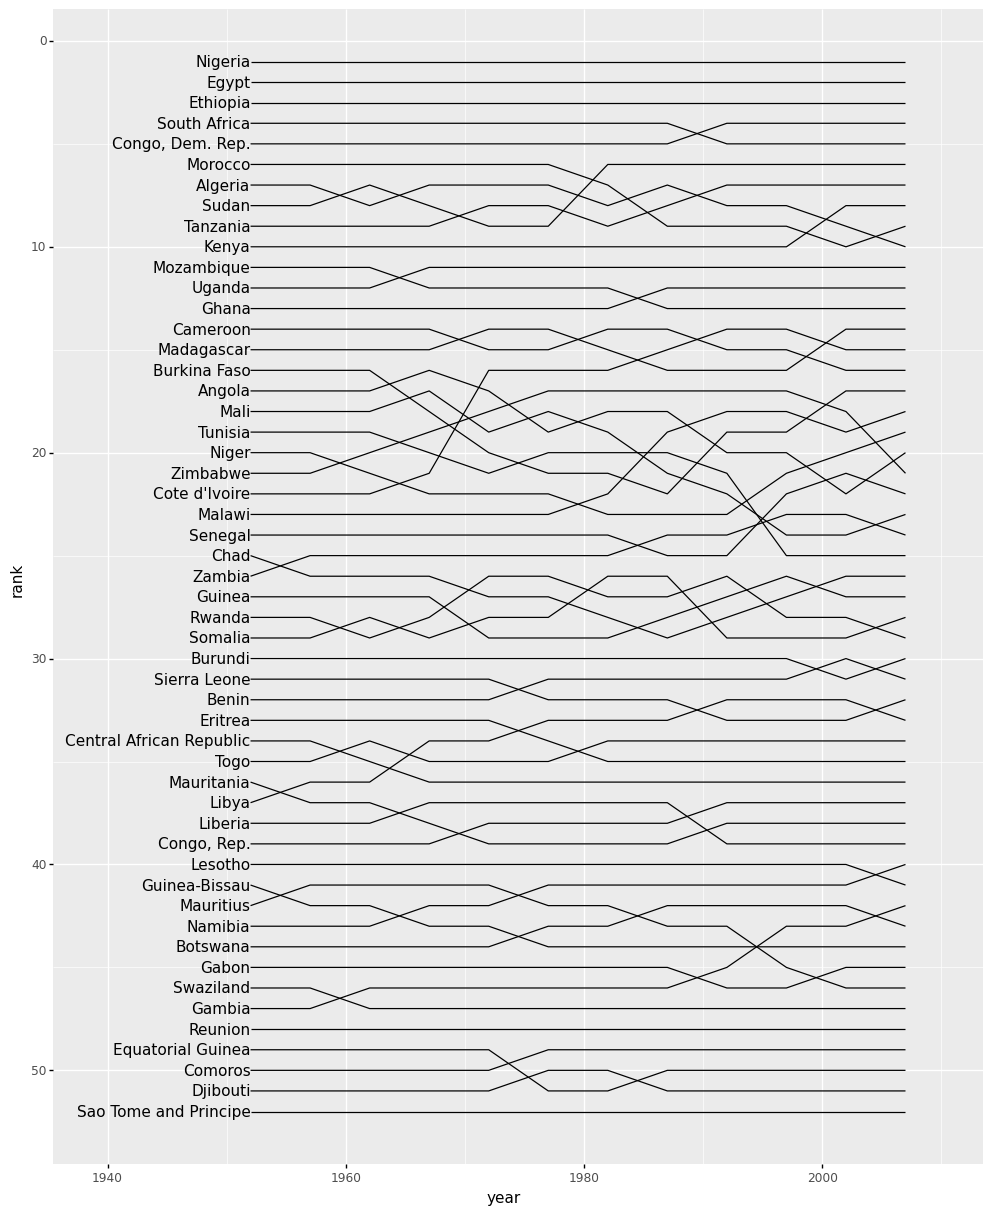

<ggplot: (8761980715695)>

In [ ]:
rank_dat = (
    gapminder
    .query('continent == "Africa"')
    .set_categorical('country', 'pop', ascending=False)
    .groupby('year')
    .apply(lambda df: df.assign(rank=df['pop'].rank(ascending=False)))
    .reset_index(drop=True)
    )

(rank_dat
  .ggplot(aes(x='year', y='rank', groups='country'))
  + geom_line()
  + geom_text(data=rank_dat.query('year==1952'), x=1952,
     mapping=aes(y='rank', label='country'),ha='right',
     show_legend=False)
  + scale_y_reverse()
  + coord_cartesian(xlim=(1939, 2010))
  + theme(figure_size=(12, 15))
)